In [1]:
import numpy as np
from IPython import display
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import random
from matplotlib import cm 
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from time import sleep
import plotly.graph_objects as go
import tensorflow as tf

extra_std = 0.01

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
# Sphere
def Sphere_f(x):
    f = 0
    for i in x:
        f += i**2
    return f

# Zakharov
def Zakharov_f(x):
  sum1 = 0
  sum2 = 0
  length=len(x)
  for i in range(1,length+1):
    zi=x[i-1]
    sum1=sum1+zi*zi
    sum2=sum2+0.5*i*zi
  res=sum1+np.power(sum2,2)+np.power(sum2,4)
  return res

# Rosenbrock
def Rosenbrock_f(x):
    f = 0
    for i in range(len(x) - 1):
        f += (100*((x[i + 1] - x[i]**2)**2) + (1 -x[i])**2)
    return f

# Michalewicz
def Michalewicz_f(x):
  m=10
  sum = 0
  length=len(x)
  pi = 3.14
  for i in range(1,length+1):
    X = x[i-1];
    if X>pi or X<0:
      new=500000
    else:
      new =-np.sin(X) * np.sin((i * X**2) / np.pi)**20
    sum  = sum + new;
  return sum

# Ackley
def Ackley_f(x):
    a = 20
    b = 0.2
    c = 2 * np.pi
    f1 = 0
    f2 = 0
    for i in range(len(x)):
        f1 += x[i] ** 2
        f2 += np.cos(c * x[i])
    p1 = -a * np.exp(-b * np.sqrt(f1 / len(x)))
    p2 = -np.exp(f2 / len(x))

    return p1 + p2 + a + np.exp(1)

In [4]:
def DE(fobj, dimension, bounds, F_scale, cross_prob, popsize, max_evals):

    lower_bound, upper_bound = np.asarray(bounds).T

    eps = 0.00001

    diff = np.fabs(lower_bound - upper_bound)

    pop = lower_bound + diff * np.random.rand(popsize, dimension)

    fitness = np.asarray([fobj(ind) for ind in pop])
    num_eval = 1
    
    best_idx = np.argmin(fitness)
    best = pop[best_idx]

    results = []
    all_fitness = []
    all_evals = []
    all_pops = []
    results.append((np.copy(best), fitness[best_idx], num_eval))
    all_pops.append(np.copy(pop))
    generation_count = 0
    
    while True:
        if num_eval > max_evals:
            break
        for i in range(popsize):

            idxes = [idx for idx in range(popsize) if idx != i]
            a, b, c = pop[np.random.choice(idxes, 3, replace=False)]
            mutant = np.clip(F_scale*(b - c) + a, lower_bound, upper_bound)

            cross_points = np.random.rand(dimension) < cross_prob
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimension)] = True
            
            trial = np.where(cross_points, mutant, pop[i])

            f = fobj(trial)
            num_eval += 1

            if f < fitness[i]:
                pop[i] = trial
                fitness[i] = f 
                if f < fitness[best_idx]:
                    best = trial
                    best_idx = i

        results.append((np.copy(best), fitness[best_idx], num_eval))
        all_fitness.append(fitness[best_idx])
        all_evals.append(num_eval)
        all_pops.append(np.copy(pop))

        if fobj(best) < eps:
            num_eval += 1
            break

        generation_count += 1

    return results, all_pops, generation_count, all_fitness, all_evals

In [51]:
def CEM(fobj, dimensions, bounds, popsize, num_elite, sigma_init, extra_std, max_evals):
    eps = 1e-4
    lower_bound, upper_bound = np.asarray(bounds).T
    sigma = sigma_init * np.eye(dimensions)

    diff = np.fabs(lower_bound - upper_bound)
    n_evals = 0
    num_evals = [0]
    mu = np.random.rand(dimensions) - (upper_bound + 1)
    #mu = lower_bound + diff * np.random.rand(dimensions)
    generation_count = 0
    all_mu = []
    all_sigma = []
    all_offspring = []
    all_elite = []
    all_fitness = []
    all_pops = []
    
    
    while True:
    # for i in range(10000):
        if n_evals > max_evals:
            break
        all_mu.append(mu)
        all_sigma.append(sigma)
        x = np.random.multivariate_normal(mu, sigma, popsize)
        
        # print(np.sum(x))
        all_offspring.append(x)
        fitness = np.array([fobj(x[i]) for i in range(popsize)])
        n_evals += popsize
        best_fitness = min(fitness) 
        all_fitness.append(best_fitness)
        #best_idx = np.argmin(fitness)
        #all_fitness.append(fitness[best_idx])
        # print(x)
        if best_fitness < eps or np.sum(x) > 1e150 or np.sum(x) < -1e150:
            break

        elite_idx = fitness.argsort()[:num_elite]
        all_elite.append(elite_idx)
        #mu = np.mean(x[elite_idx], axis=0)

        #z=x[elite_idx]
        #sigma =np.std(z, ddof=1 ,axis=0) + eps
        #generation_count += 1
        #num_evals.append(n_evals)
        #all_pops.append(x)
        #new_means = np.mean(x[elite_idx], axis=0)
        #new_means = np.tile(new_means,(popsize,1))
        #x=np.random.normal(new_means,sigma)

        sigma = np.zeros_like(sigma)
        for i in range(num_elite):
            z = x[elite_idx[i]] - mu
            z = z.reshape(-1, 1)
            # print(num_evals)
            sigma += tf.matmul(z.T, z)
            # sigma += (z.T * z)
            #sigma += (z.T @ z)

        sigma += np.eye(dimension)*extra_std
        sigma *= (1/num_elite)
        mu = np.mean(x[elite_idx], axis=0)
        generation_count += 1
        num_evals.append(n_evals)
        all_pops.append(np.copy(x))

    all_mu.append(mu)
    best_results = mu.copy()
    best_fitness = fobj(mu)
    return all_mu, all_fitness, num_evals, generation_count, all_pops

In [74]:
def CEM2(fobj, dimensions, bounds, popsize, num_elite, sigma_init, extra_std, max_evals):
    eps = 1e-4
    lower_bound, upper_bound = np.asarray(bounds).T
    sigma = sigma_init * np.eye(dimensions)

    diff = np.fabs(lower_bound - upper_bound)
    n_evals = 0
    num_evals = [0]
    #mu = np.random.rand(dimensions) - (upper_bound + 1)
    mu = lower_bound + diff * np.random.rand(dimensions)
    generation_count = 0
    all_mu = []
    all_sigma = []
    all_offspring = []
    all_elite = []
    all_fitness = []
    all_pops = []
    x = np.random.multivariate_normal(mu, sigma, popsize)
    
    while True:
    # for i in range(10000):
        if n_evals > max_evals:
            break
        all_mu.append(mu)
        all_sigma.append(sigma)

        
        # print(np.sum(x))
        all_offspring.append(x)
        fitness = np.array([fobj(x[i]) for i in range(popsize)])
        n_evals += popsize
        best_fitness = min(fitness) 
        all_fitness.append(best_fitness)
        #best_idx = np.argmin(fitness)
        #all_fitness.append(fitness[best_idx])
        # print(x)
        #if best_fitness < eps or np.sum(x) > 1e150 or np.sum(x) < -1e150:
            #break

        elite_idx = fitness.argsort()[:num_elite]
        all_elite.append(elite_idx)
        mu = np.mean(x[elite_idx], axis=0)

        z=x[elite_idx]
        sigma =np.std(z, ddof=1 ,axis=0) + eps
        generation_count += 1
        num_evals.append(n_evals)
        all_pops.append(x)
        new_means = np.mean(x[elite_idx], axis=0)
        new_means = np.tile(new_means,(popsize,1))
        x=np.random.normal(new_means,sigma)

        #sigma = np.zeros_like(sigma)
        #for i in range(num_elite):
            #z = x[elite_idx[i]] - mu
            #z = z.reshape(-1, 1)
            # print(num_evals)
            #sigma += tf.matmul(z.T, z)
            # sigma += (z.T * z)
            #sigma += (z.T @ z)

        #sigma += np.eye(dimension)*extra_std
        #sigma *= (1/num_elite)
        #mu = np.mean(x[elite_idx], axis=0)
        #generation_count += 1
        #num_evals.append(n_evals)
        #all_pops.append(np.copy(x))

    all_mu.append(mu)
    best_results = mu.copy()
    best_fitness = fobj(mu)
    return all_mu, all_fitness, num_evals, generation_count, all_pops

In [7]:
!pip install celluloid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from celluloid import Camera
import cv2
def F(x, y):
  res = 20.0
  res += (x*x - 10*np.cos(2*np.pi*x))
  res += (y*y - 10*np.cos(2*np.pi*y))
  return res

In [9]:
def create_gif(all_pops, video_name, nmR = -10, mR = 10, nP = 100):
  # Tạo ảnh plt.contourf
  x = np.linspace(nmR, mR, nP)
  y =  np.linspace(nmR, mR, nP)

  X, Y = np.meshgrid(x, y)
  Z = F(X, Y)

  plt.contourf(X, Y, Z, 20, cmap='jet', alpha=0.8)
  plt.axis('off')
  plt.savefig('setup.jpg')
  img = cv2.imread('setup.jpg') # Read in the image and convert to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray = 255*(gray < 128).astype(np.uint8) # To invert the text to white
  coords = cv2.findNonZero(gray) # Find all non-zero points (text)
  x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box
  rect = img[y:y+h, x:x+w] # Crop the image - note we do this on the original image
  #cv2_imshow( rect) # Show it
  cv2.waitKey(0)
  cv2.destroyAllWindows()
  cv2.imwrite("rect.png", rect) # Save the image


  #animation
  camera = Camera(plt.figure())
  #fig=plt.figure(figsize=(6,6))
  #fig=plt.figure()
  img = plt.imread('/content/rect.png')
  plt.axis('square')
  ax = plt.axes(xlim=(nmR, mR), ylim=(nmR, mR))
  ax.imshow(img, extent=[nmR, mR, nmR, mR], aspect='auto')
  tR=mR-0.8
  #length=len(all_pops)
  length=len(all_pops)
  print(length)
  for i in range(0,min(100,length)):
    #plt.title("iters"+str(i))
    #plt.contourf(X, Y, Z, 20, cmap='jet', alpha=0.8)
    #plt.imread()
    plt.text(tR,tR,str(i),color='black',fontsize=12)
    ax.imshow(img, extent=[nmR, mR, nmR, mR], aspect='auto')
    plt.scatter(all_pops[i][:,0], all_pops[i][:,1], s=30, c='black')
    #plt.scatter([4],[4],s=100,c='black')
    camera.snap()
  anim = camera.animate(blit=True)
  anim.save(video_name)#/'scatter.mp4'


In [10]:
def cal(all_fitness, all_evals):
  plt_fitness_es_1024 = []
  plt_std_es_1024 = []
  plt_eval_es_1024 = []
  for i in range(np.min([len(all_fitness[t]) for t in range(10)])):
    fitness = []
    eval = []
    for j in range(10):
        fitness.append(all_fitness[j][i])
        eval.append(all_evals[j][i])
    plt_fitness_es_1024.append(np.mean(fitness))
    plt_std_es_1024.append(np.std(fitness))
    plt_eval_es_1024.append(np.mean(eval))
  return plt_fitness_es_1024, plt_std_es_1024, plt_eval_es_1024

In [11]:
def show_fig(all_fitness_de_128, evals_de_128, all_fitness_de_1024, evals_de_1024, all_fitness_cem_128, evals_cem_128, all_fitness_cem_1024, evals_cem_1024, min_y=0, max_y=2):
  mean_de_128, std_de_128, eval_mean_de_128 = cal(all_fitness_de_128, evals_de_128)
  error1_cem_128, error2_cem_128 = [], []
  for i in range(len(mean_de_128)):
    error1_cem_128.append(mean_de_128[i] + std_de_128[i])
    error2_cem_128.append(mean_de_128[i] - std_de_128[i])

  mean_de_1024, std_de_1024, eval_mean_de_1024 = cal(all_fitness_de_1024, evals_de_1024)
  error1_cem_1024, error2_cem_1024 = [], []
  for i in range(len(mean_de_1024)):
    error1_cem_1024.append(mean_de_1024[i] + std_de_1024[i])
    error2_cem_1024.append(mean_de_1024[i] - std_de_1024[i])

  mean_cem_128, std_cem_128, eval_mean_cem_128 = cal(all_fitness_cem_128, evals_cem_128)
  error1_cemv2_128, error2_cemv2_128 = [], []
  for i in range(len(mean_cem_128)):
    error1_cemv2_128.append(mean_cem_128[i] + std_cem_128[i])
    error2_cemv2_128.append(mean_cem_128[i] - std_cem_128[i])

  mean_cem_1024, std_cem_1024, eval_mean_cem_1024 = cal(all_fitness_cem_1024, evals_cem_1024)
  error1_cemv2_1024, error2_cemv2_1024 = [], []
  for i in range(len(mean_cem_1024)):
    error1_cemv2_1024.append(mean_cem_1024[i] + std_cem_1024[i])
    error2_cemv2_1024.append(mean_cem_1024[i] - std_cem_1024[i])

  temp = []
  temp.append(max(eval_mean_de_128))
  temp.append(max(eval_mean_de_1024))
  temp.append(max(eval_mean_cem_128))
  temp.append(max(eval_mean_cem_1024))
  max_x = max(temp)
  plt.figure(figsize=(12, 6))
  plt.xlim(left=0, right=max_x)
  plt.ylim(min_y, max_y)
  #plt.yscale('log')
  plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

  # DE 128
  plt.plot(eval_mean_de_128, mean_de_128, label='DE-128')
  plt.fill_between(eval_mean_de_128, error1_cem_128, error2_cem_128, alpha=0.2)

  # DE 1024
  plt.plot(eval_mean_de_1024, mean_de_1024, label='DE-1024')
  plt.fill_between(eval_mean_de_1024, error1_cem_1024, error2_cem_1024, alpha=0.2)

  # CEMv2 128
  plt.plot(eval_mean_cem_128, mean_cem_128,label='CEM-128')
  plt.fill_between(eval_mean_cem_128, error1_cemv2_128, error2_cemv2_128, alpha=0.2)

  # ES 1024
  plt.plot(eval_mean_cem_1024, mean_cem_1024, label='CEM-1024')
  plt.fill_between(eval_mean_cem_1024, error1_cemv2_1024, error2_cemv2_1024, alpha=0.2)

  plt.xlabel('Number of function evaluations')
  plt.ylabel('Best fitness')
  plt.legend()
  plt.savefig('Sphere-2d.png')
  plt.show()

# **HÀM SPHERE**

## DIMENSION = 2

In [12]:
dimension = 2

In [13]:
F_scale=0.8
cross_prob=0.7
num_elite = 10
sigma_init = 4
lower_bound = -6
upper_bound = 6
max_evals = 1e5
fobj = Sphere_f
popsize = 32
mean_sphere_2d_DE = []
mean_sphere_2d_CEM = []
std_sphere_2d_DE = []
std_sphere_2d_CEM = []

while True:
  if popsize > 1024:
    break
  all_results_de = []
  all_fitness_de = []
  num_evals_de = []
  all_results_cem = []
  all_fitness_cem = []
  all_fitness_cem_temp = []
  num_evals_cem = []
  num_evals_cem_temp = []
  seed_number= 17520618

  for i in range(10):
    np.random.rand(seed_number)
    results_de, all_pops_de, generation_count_de, fitness_de, eval_de = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results_de.append(results_de[-1])
    all_fitness_de.append(fitness_de)
    num_evals_de.append(eval_de)
    results_cem, fitness_cem, evals_cem, generation_count_cem, all_pops_cem = CEM(fobj, dimension, [(lower_bound, upper_bound)]*dimension, popsize, num_elite, sigma_init, extra_std, max_evals)
    all_results_cem.append(results_cem[-1])
    all_fitness_cem.append(fitness_cem[-1])
    num_evals_cem.append(evals_cem[-1])
    all_fitness_cem_temp.append(fitness_cem)
    num_evals_cem_temp.append(evals_cem)
    seed_number += 1
  if popsize == 32:
    pop_de = all_pops_de
    pop_cem = all_pops_cem
  elif popsize == 128:
    all_fitness_de_128 = all_fitness_de
    evals_de_128 = num_evals_de
    all_fitness_cem_128 = all_fitness_cem_temp
    evals_cem_128 = num_evals_cem_temp
  elif popsize == 1024:
    all_fitness_de_1024 = all_fitness_de
    evals_de_1024 = num_evals_de
    all_fitness_cem_1024 = all_fitness_cem_temp
    evals_cem_1024 = num_evals_cem_temp
  
  print('popsize =', popsize)
  print('DE:')
  for i in range(10):
    print(all_results_de[i])
  print('---------------------------------------------------------')
  print('CEM')
  for i in range(10):
    print(all_results_cem[i], all_fitness_cem[i], num_evals_cem[i])

  print(f"Giá trị trung bình (mean) của Sphere trong DE: {np.mean([all_results_de[i][1] for i in range(len(all_results_de))])}")
  mean_sphere_2d_DE.append(np.mean([all_results_de[i][1] for i in range(len(all_results_de))]))
  print(f"Độ lệch chuẩn (std) của Sphere trong DE: {np.std([all_results_de[i][1] for i in range(len(all_results_de))])}")
  std_sphere_2d_DE.append(np.std([all_results_de[i][1] for i in range(len(all_results_de))]))
  print(f"Giá trị trung bình (mean) của Sphere trong CEM: {np.mean([all_fitness_cem[i] for i in range(len(all_results_cem))])}")
  mean_sphere_2d_CEM.append(np.mean([all_fitness_cem[i] for i in range(len(all_results_cem))]))
  print(f"Độ lệch chuẩn (std) của Sphere trong CEM: {np.std([all_fitness_cem[i] for i in range(len(all_results_cem))])}")
  std_sphere_2d_CEM.append(np.std([all_fitness_cem[i] for i in range(len(all_results_cem))]))
  print('===========================================================')

  popsize = popsize*2

popsize = 32
DE:
(array([-0.00111006,  0.00046033]), 1.4441358924945902e-06, 1057)
(array([ 0.00100885, -0.00082604]), 1.7001104575184923e-06, 1025)
(array([0.00199491, 0.00089978]), 4.789275639177435e-06, 833)
(array([-0.00029146,  0.00018841]), 1.2044793657677893e-07, 833)
(array([ 0.00225125, -0.00106711]), 6.206849730638767e-06, 1057)
(array([-0.00011513,  0.00098018]), 9.740168970862e-07, 801)
(array([-0.00125916,  0.00140849]), 3.5693466270836192e-06, 833)
(array([ 0.00157973, -0.0024247 ]), 8.374737905694228e-06, 865)
(array([-0.00109796,  0.00037593]), 1.3468444844058772e-06, 929)
(array([-0.00168052,  0.00086427]), 3.5711053257980814e-06, 897)
---------------------------------------------------------
CEM
[ 0.05519029 -0.02806733] 2.2259008880199573e-05 1056
[0.00412751 0.00099351] 1.3111884562449078e-05 544
[-0.01514694 -0.00073904] 7.051958936167313e-05 896
[ 0.00662476 -0.02402203] 4.073929283221239e-06 1088
[ 0.00449674 -0.01053176] 9.88869042679412e-05 1312
[ 0.03920949 -0

In [14]:
for i in range(6):
  print('DE:', mean_sphere_2d_DE[i], std_sphere_2d_DE[i])
  print('CEM:', mean_sphere_2d_CEM[i], std_sphere_2d_CEM[i])

DE: 3.2096870896474068e-06 2.486435338063497e-06
CEM: 4.356801719991689e-05 3.363993529904233e-05
DE: 5.073999214432519e-06 2.225168280523552e-06
CEM: 3.491510637373595e-05 2.3410741787437977e-05
DE: 4.717018703795592e-06 3.085871732553211e-06
CEM: 3.7315658515494397e-05 2.6598540693685593e-05
DE: 4.3118153653383495e-06 3.363069616961902e-06
CEM: 3.177395712972363e-05 2.687335574699022e-05
DE: 4.955813319218455e-06 2.151413706396705e-06
CEM: 2.7816354597458797e-05 1.914227586188144e-05
DE: 5.006789443058013e-06 2.6516079256303564e-06
CEM: 2.301748364840356e-05 2.072152528374848e-05


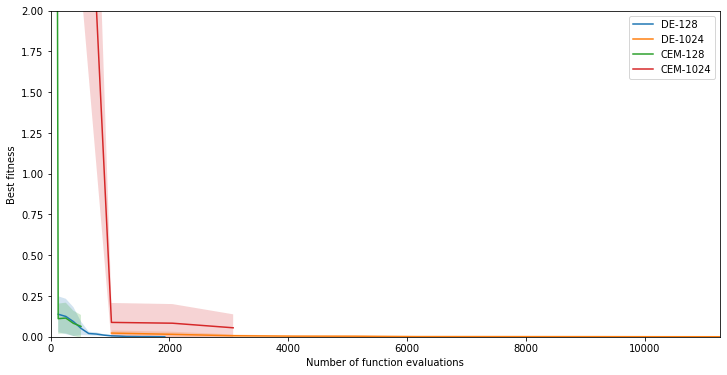

In [15]:
show_fig(all_fitness_de_128, evals_de_128, all_fitness_de_1024, evals_de_1024, all_fitness_cem_128, evals_cem_128, all_fitness_cem_1024, evals_cem_1024)

## DIMENSION = 10

In [16]:
dimension = 10

In [17]:
F_scale=0.8
cross_prob=0.7
num_elite = 10
sigma_init = 4
lower_bound = -6
upper_bound = 6
max_evals = 1e6
fobj = Sphere_f
popsize = 32
mean_sphere_2d_DE = []
mean_sphere_2d_CEM = []
std_sphere_2d_DE = []
std_sphere_2d_CEM = []

while True:
  if popsize > 1024:
    break
  all_results_de = []
  all_fitness_de = []
  num_evals_de = []
  all_results_cem = []
  all_fitness_cem = []
  all_fitness_cem_temp = []
  num_evals_cem = []
  num_evals_cem_temp = []
  seed_number= 17520618

  for i in range(10):
    np.random.rand(seed_number)
    results_de, all_pops_de, generation_count_de, fitness_de, eval_de = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results_de.append(results_de[-1])
    all_fitness_de.append(fitness_de)
    num_evals_de.append(eval_de)
    results_cem, fitness_cem, evals_cem, generation_count_cem, all_pops_cem = CEM(fobj, dimension, [(lower_bound, upper_bound)]*dimension, popsize, num_elite, sigma_init, extra_std, max_evals)
    all_results_cem.append(results_cem[-1])
    all_fitness_cem.append(fitness_cem[-1])
    num_evals_cem.append(evals_cem[-1])
    all_fitness_cem_temp.append(fitness_cem)
    num_evals_cem_temp.append(evals_cem)
    seed_number += 1
  if popsize == 32:
    pop_de = all_pops_de
    pop_cem = all_pops_cem
  elif popsize == 128:
    all_fitness_de_128 = all_fitness_de
    evals_de_128 = num_evals_de
    all_fitness_cem_128 = all_fitness_cem_temp
    evals_cem_128 = num_evals_cem_temp
  elif popsize == 1024:
    all_fitness_de_1024 = all_fitness_de
    evals_de_1024 = num_evals_de
    all_fitness_cem_1024 = all_fitness_cem_temp
    evals_cem_1024 = num_evals_cem_temp
  
  print('popsize =', popsize)
  print('DE:')
  for i in range(10):
    print(all_results_de[i])
  print('---------------------------------------------------------')
  print('CEM')
  for i in range(10):
    print(all_results_cem[i], all_fitness_cem[i], num_evals_cem[i])

  print(f"Giá trị trung bình (mean) của Sphere trong DE: {np.mean([all_results_de[i][1] for i in range(len(all_results_de))])}")
  mean_sphere_2d_DE.append(np.mean([all_results_de[i][1] for i in range(len(all_results_de))]))
  print(f"Độ lệch chuẩn (std) của Sphere trong DE: {np.std([all_results_de[i][1] for i in range(len(all_results_de))])}")
  std_sphere_2d_DE.append(np.std([all_results_de[i][1] for i in range(len(all_results_de))]))
  print(f"Giá trị trung bình (mean) của Sphere trong CEM: {np.mean([all_fitness_cem[i] for i in range(len(all_results_cem))])}")
  mean_sphere_2d_CEM.append(np.mean([all_fitness_cem[i] for i in range(len(all_results_cem))]))
  print(f"Độ lệch chuẩn (std) của Sphere trong CEM: {np.std([all_fitness_cem[i] for i in range(len(all_results_cem))])}")
  std_sphere_2d_CEM.append(np.std([all_fitness_cem[i] for i in range(len(all_results_cem))]))
  print('===========================================================')

  popsize = popsize*2

popsize = 32
DE:
(array([ 0.00123199, -0.00104837,  0.00185379, -0.00046236, -0.00062785,
       -0.00112121,  0.00040448,  0.00077389, -0.00043776, -0.00036943]), 9.009100299295734e-06, 10273)
(array([ 1.69234003e-03,  4.22302061e-04, -1.91539847e-05, -5.11635744e-04,
       -1.29271352e-03,  6.52634664e-04, -4.93843220e-04, -3.85397889e-04,
        1.01305558e-03,  1.25459249e-03]), 8.39422864859024e-06, 10689)
(array([ 7.05399031e-04,  1.69296959e-03, -7.73040634e-05, -1.05848213e-03,
       -4.49832168e-04,  9.49238147e-04,  3.81334253e-04,  1.32867386e-03,
        1.04778345e-03, -1.22153392e-04]), 8.617057852340798e-06, 10561)
(array([-0.00047917,  0.00084703,  0.00031132,  0.00037362,  0.00011267,
        0.00124266,  0.00113911,  0.00238964,  0.00028863,  0.00030803]), 9.92662166938896e-06, 10241)
(array([-0.00097971,  0.00063651,  0.00030197,  0.00091126,  0.00058852,
        0.00075086,  0.00030775,  0.00111817, -0.00091243,  0.00030764]), 5.468890563102447e-06, 10689)
(array

In [18]:
for i in range(6):
  print('DE:', mean_sphere_2d_DE[i], std_sphere_2d_DE[i])
  print('CEM:', mean_sphere_2d_CEM[i], std_sphere_2d_CEM[i])

DE: 8.652922609516318e-06 1.1899819254910341e-06
CEM: 0.02850815251249088 0.01133275528364519
DE: 7.88518408935345e-06 1.4552803173297475e-06
CEM: 0.005473421587138527 0.0014426976107248244
DE: 8.23016824982326e-06 1.3337593424302236e-06
CEM: 0.0040223957170955945 0.0014141384918248449
DE: 7.84117846461264e-06 1.8094468718765792e-06
CEM: 0.002952295611146224 0.0007055029048683142
DE: 8.062198732069165e-06 1.645627391791181e-06
CEM: 0.002798014899267615 0.0006950221521928813
DE: 8.586417709350845e-06 1.1933814403750716e-06
CEM: 0.0018839469597203388 0.0004239449039041217


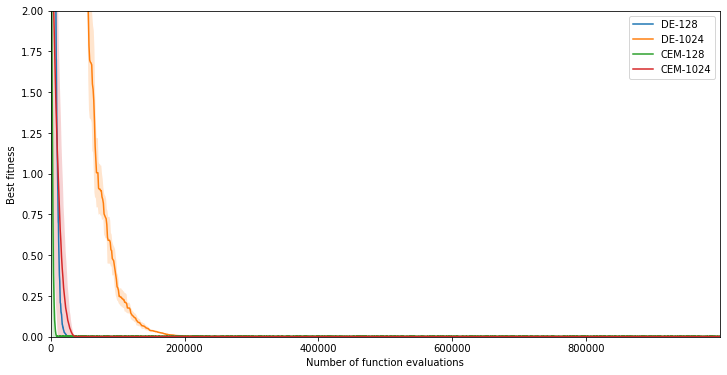

In [19]:
show_fig(all_fitness_de_128, evals_de_128, all_fitness_de_1024, evals_de_1024, all_fitness_cem_128, evals_cem_128, all_fitness_cem_1024, evals_cem_1024)

# **HÀM ZAKHAROV**

## DIMENSION = 2

In [24]:
dimension = 2

In [25]:
F_scale=0.8
cross_prob=0.7
num_elite = 10
sigma_init = 4
lower_bound = -6
upper_bound = 6
max_evals = 1e5
fobj = Zakharov_f
popsize = 32
mean_sphere_2d_DE = []
mean_sphere_2d_CEM = []
std_sphere_2d_DE = []
std_sphere_2d_CEM = []

while True:
  if popsize > 1024:
    break
  all_results_de = []
  all_fitness_de = []
  num_evals_de = []
  all_results_cem = []
  all_fitness_cem = []
  all_fitness_cem_temp = []
  num_evals_cem = []
  num_evals_cem_temp = []
  seed_number= 17520618

  for i in range(10):
    np.random.rand(seed_number)
    results_de, all_pops_de, generation_count_de, fitness_de, eval_de = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results_de.append(results_de[-1])
    all_fitness_de.append(fitness_de)
    num_evals_de.append(eval_de)
    results_cem, fitness_cem, evals_cem, generation_count_cem, all_pops_cem = CEM(fobj, dimension, [(lower_bound, upper_bound)]*dimension, popsize, num_elite, sigma_init, extra_std, max_evals)
    all_results_cem.append(results_cem[-1])
    all_fitness_cem.append(fitness_cem[-1])
    num_evals_cem.append(evals_cem[-1])
    all_fitness_cem_temp.append(fitness_cem)
    num_evals_cem_temp.append(evals_cem)
    seed_number += 1
  if popsize == 32:
    pop_de = all_pops_de
    pop_cem = all_pops_cem
  elif popsize == 128:
    all_fitness_de_128 = all_fitness_de
    evals_de_128 = num_evals_de
    all_fitness_cem_128 = all_fitness_cem_temp
    evals_cem_128 = num_evals_cem_temp
  elif popsize == 1024:
    all_fitness_de_1024 = all_fitness_de
    evals_de_1024 = num_evals_de
    all_fitness_cem_1024 = all_fitness_cem_temp
    evals_cem_1024 = num_evals_cem_temp
  
  print('popsize =', popsize)
  print('DE:')
  for i in range(10):
    print(all_results_de[i])
  print('---------------------------------------------------------')
  print('CEM')
  for i in range(10):
    print(all_results_cem[i], all_fitness_cem[i], num_evals_cem[i])

  print(f"Giá trị trung bình (mean) của Zakharov trong DE: {np.mean([all_results_de[i][1] for i in range(len(all_results_de))])}")
  mean_sphere_2d_DE.append(np.mean([all_results_de[i][1] for i in range(len(all_results_de))]))
  print(f"Độ lệch chuẩn (std) của Zakharov trong DE: {np.std([all_results_de[i][1] for i in range(len(all_results_de))])}")
  std_sphere_2d_DE.append(np.std([all_results_de[i][1] for i in range(len(all_results_de))]))
  print(f"Giá trị trung bình (mean) của Zakharov trong CEM: {np.mean([all_fitness_cem[i] for i in range(len(all_results_cem))])}")
  mean_sphere_2d_CEM.append(np.mean([all_fitness_cem[i] for i in range(len(all_results_cem))]))
  print(f"Độ lệch chuẩn (std) của Zakharov trong CEM: {np.std([all_fitness_cem[i] for i in range(len(all_results_cem))])}")
  std_sphere_2d_CEM.append(np.std([all_fitness_cem[i] for i in range(len(all_results_cem))]))
  print('===========================================================')

  popsize = popsize*2

popsize = 32
DE:
(array([ 0.00287941, -0.00035717]), 9.590437793168223e-06, 1121)
(array([ 0.00028049, -0.00016727]), 1.0738448217034887e-07, 1057)
(array([-0.00184684,  0.00193991]), 8.207345009635894e-06, 1185)
(array([ 0.00238622, -0.00105256]), 6.8216799000177095e-06, 961)
(array([ 0.00084993, -0.00122041]), 2.844520231031417e-06, 865)
(array([-0.0006663 , -0.00036852]), 1.0720965434122106e-06, 897)
(array([-0.00027938, -0.00075635]), 1.4530169597901158e-06, 1025)
(array([-0.00100619, -0.00117535]), 5.211053720972889e-06, 1441)
(array([-0.00204174, -0.0006001 ]), 7.156386856531064e-06, 961)
(array([8.27902783e-04, 1.80678108e-06]), 8.582811698732539e-07, 1249)
---------------------------------------------------------
CEM
[-0.01461976  0.02545407] 8.75673420754768e-05 384
[-0.03574568  0.03956855] 5.430878534783666e-05 256
[ 0.00679734 -0.00410468] 1.3870819527849972e-05 480
[-0.03357301  0.00250664] 2.148128550157999e-05 736
[-0.04503343  0.03784139] 4.5087192076193286e-05 928
[-0.

In [26]:
for i in range(6):
  print('DE:', mean_sphere_2d_DE[i], std_sphere_2d_DE[i])
  print('CEM:', mean_sphere_2d_CEM[i], std_sphere_2d_CEM[i])

DE: 4.332220266660312e-06 3.2963628105360887e-06
CEM: 4.9420086924207034e-05 3.203867770780163e-05
DE: 5.448596299478372e-06 3.0685921084977842e-06
CEM: 2.0080883835220225e-05 1.7191354091160956e-05
DE: 4.3892353525685765e-06 2.564482207792974e-06
CEM: 3.3997868435035526e-05 2.77612255258355e-05
DE: 6.4085735901695735e-06 3.2864773379656096e-06
CEM: 3.7344359845588955e-05 2.713761861903711e-05
DE: 3.985552075649017e-06 2.088885398124085e-06
CEM: 2.84228196660034e-05 2.0090477053942596e-05
DE: 5.393777991283624e-06 2.6843600285748177e-06
CEM: 3.8663745254533736e-05 3.6876277730567125e-05


40
46


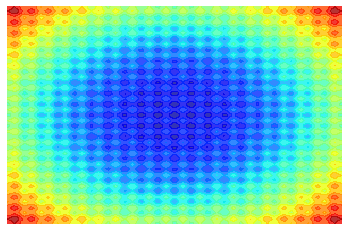

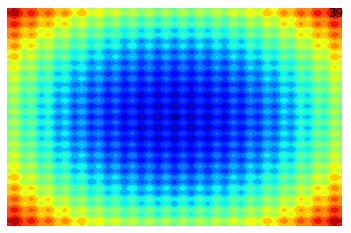

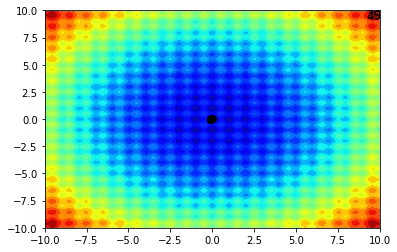

In [27]:
create_gif(pop_de, '/DE_ZAKHAROV.mp4')
create_gif(pop_cem, '/CEM_ZAKHAROV.mp4')

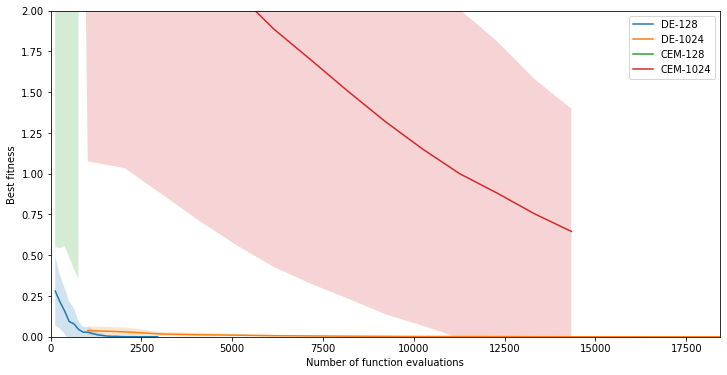

In [28]:
show_fig(all_fitness_de_128, evals_de_128, all_fitness_de_1024, evals_de_1024, all_fitness_cem_128, evals_cem_128, all_fitness_cem_1024, evals_cem_1024)

## DIMENSION = 10

In [29]:
dimension = 10

In [30]:
F_scale=0.8
cross_prob=0.7
num_elite = 10
sigma_init = 4
lower_bound = -6
upper_bound = 6
max_evals = 1e6
fobj = Zakharov_f
popsize = 32
mean_sphere_2d_DE = []
mean_sphere_2d_CEM = []
std_sphere_2d_DE = []
std_sphere_2d_CEM = []

while True:
  if popsize > 1024:
    break
  all_results_de = []
  all_fitness_de = []
  num_evals_de = []
  all_results_cem = []
  all_fitness_cem = []
  all_fitness_cem_temp = []
  num_evals_cem = []
  num_evals_cem_temp = []
  seed_number= 17520618

  for i in range(10):
    np.random.rand(seed_number)
    results_de, all_pops_de, generation_count_de, fitness_de, eval_de = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results_de.append(results_de[-1])
    all_fitness_de.append(fitness_de)
    num_evals_de.append(eval_de)
    results_cem, fitness_cem, evals_cem, generation_count_cem, all_pops_cem = CEM(fobj, dimension, [(lower_bound, upper_bound)]*dimension, popsize, num_elite, sigma_init, extra_std, max_evals)
    all_results_cem.append(results_cem[-1])
    all_fitness_cem.append(fitness_cem[-1])
    num_evals_cem.append(evals_cem[-1])
    all_fitness_cem_temp.append(fitness_cem)
    num_evals_cem_temp.append(evals_cem)
    seed_number += 1
  if popsize == 32:
    pop_de = all_pops_de
    pop_cem = all_pops_cem
  elif popsize == 128:
    all_fitness_de_128 = all_fitness_de
    evals_de_128 = num_evals_de
    all_fitness_cem_128 = all_fitness_cem_temp
    evals_cem_128 = num_evals_cem_temp
  elif popsize == 1024:
    all_fitness_de_1024 = all_fitness_de
    evals_de_1024 = num_evals_de
    all_fitness_cem_1024 = all_fitness_cem_temp
    evals_cem_1024 = num_evals_cem_temp
  
  print('popsize =', popsize)
  print('DE:')
  for i in range(10):
    print(all_results_de[i])
  print('---------------------------------------------------------')
  print('CEM')
  for i in range(10):
    print(all_results_cem[i], all_fitness_cem[i], num_evals_cem[i])

  print(f"Giá trị trung bình (mean) của Zakharov trong DE: {np.mean([all_results_de[i][1] for i in range(len(all_results_de))])}")
  mean_sphere_2d_DE.append(np.mean([all_results_de[i][1] for i in range(len(all_results_de))]))
  print(f"Độ lệch chuẩn (std) của Zakharov trong DE: {np.std([all_results_de[i][1] for i in range(len(all_results_de))])}")
  std_sphere_2d_DE.append(np.std([all_results_de[i][1] for i in range(len(all_results_de))]))
  print(f"Giá trị trung bình (mean) của Zakharov trong CEM: {np.mean([all_fitness_cem[i] for i in range(len(all_results_cem))])}")
  mean_sphere_2d_CEM.append(np.mean([all_fitness_cem[i] for i in range(len(all_results_cem))]))
  print(f"Độ lệch chuẩn (std) của Zakharov trong CEM: {np.std([all_fitness_cem[i] for i in range(len(all_results_cem))])}")
  std_sphere_2d_CEM.append(np.std([all_fitness_cem[i] for i in range(len(all_results_cem))]))
  print('===========================================================')

  popsize = popsize*2

popsize = 32
DE:
(array([-2.13748830e-04, -1.77800655e-04, -7.65825330e-04,  6.46596832e-04,
       -8.70850846e-04, -1.15100189e-03, -7.32779355e-05, -2.14249933e-04,
        1.66238040e-05,  9.39077081e-04]), 8.565939791041854e-06, 42977)
(array([-3.53328146e-04, -7.41333634e-04,  2.15753668e-03,  7.47252623e-04,
       -2.86030959e-05, -6.22682921e-04, -4.27552125e-04, -1.90293548e-04,
       -6.72383154e-04,  8.96345373e-04]), 8.89930566498961e-06, 41441)
(array([ 5.97461982e-04,  8.10297441e-04, -1.93616085e-03, -1.12933352e-03,
       -2.98394103e-04,  9.45345242e-04,  1.21524732e-03, -6.28303539e-04,
       -8.20609487e-05,  6.58377648e-05]), 8.97260359242615e-06, 43329)
(array([-2.65782975e-04,  1.07172309e-05,  1.01798902e-03,  1.36075969e-03,
        7.33555717e-04, -9.44333743e-04, -4.11817432e-04,  9.71647951e-04,
       -1.07119629e-03,  4.29964302e-05]), 7.58677728382764e-06, 40449)
(array([-0.00152034,  0.00032654, -0.00052946,  0.00042325, -0.00021621,
       -0.0015507

In [31]:
for i in range(6):
  print('DE:', mean_sphere_2d_DE[i], std_sphere_2d_DE[i])
  print('CEM:', mean_sphere_2d_CEM[i], std_sphere_2d_CEM[i])

DE: 9.036006078757248e-06 6.850067492468148e-07
CEM: 5.8298257684650565 3.6373377453005706
DE: 8.394653649627004e-06 1.5562732421263383e-06
CEM: 0.24756234613607409 0.12569033443832495
DE: 8.583810187458738e-06 1.0091248430575352e-06
CEM: 0.03196422671354794 0.013564193153823558
DE: 8.544452908384267e-06 8.910890989256948e-07
CEM: 0.009841298096070426 0.004542457953069965
DE: 7.796350467633953e-06 1.2670335923847876e-06
CEM: 0.006151104626934899 0.0018880385613457527
DE: 0.007707079096910157 0.0016762341373090636
CEM: 0.004745669444206401 0.0014842149508220144


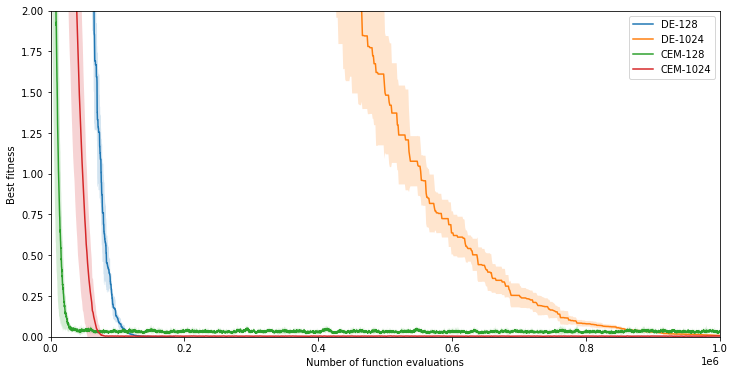

In [32]:
show_fig(all_fitness_de_128, evals_de_128, all_fitness_de_1024, evals_de_1024, all_fitness_cem_128, evals_cem_128, all_fitness_cem_1024, evals_cem_1024)

# **HÀM ROSENBROCK**

## DIMENSION = 2

In [33]:
dimension = 2

In [34]:
F_scale=0.8
cross_prob=0.7
num_elite = 10
sigma_init = 4
lower_bound = -6
upper_bound = 6
max_evals = 1e5
fobj = Rosenbrock_f
popsize = 32
mean_sphere_2d_DE = []
mean_sphere_2d_CEM = []
std_sphere_2d_DE = []
std_sphere_2d_CEM = []

while True:
  if popsize > 1024:
    break
  all_results_de = []
  all_fitness_de = []
  num_evals_de = []
  all_results_cem = []
  all_fitness_cem = []
  all_fitness_cem_temp = []
  num_evals_cem = []
  num_evals_cem_temp = []
  seed_number= 17520618

  for i in range(10):
    np.random.rand(seed_number)
    results_de, all_pops_de, generation_count_de, fitness_de, eval_de = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results_de.append(results_de[-1])
    all_fitness_de.append(fitness_de)
    num_evals_de.append(eval_de)
    results_cem, fitness_cem, evals_cem, generation_count_cem, all_pops_cem = CEM(fobj, dimension, [(lower_bound, upper_bound)]*dimension, popsize, num_elite, sigma_init, extra_std, max_evals)
    all_results_cem.append(results_cem[-1])
    all_fitness_cem.append(fitness_cem[-1])
    num_evals_cem.append(evals_cem[-1])
    all_fitness_cem_temp.append(fitness_cem)
    num_evals_cem_temp.append(evals_cem)
    seed_number += 1
  if popsize == 32:
    pop_de = all_pops_de
    pop_cem = all_pops_cem
  elif popsize == 128:
    all_fitness_de_128 = all_fitness_de
    evals_de_128 = num_evals_de
    all_fitness_cem_128 = all_fitness_cem_temp
    evals_cem_128 = num_evals_cem_temp
  elif popsize == 1024:
    all_fitness_de_1024 = all_fitness_de
    evals_de_1024 = num_evals_de
    all_fitness_cem_1024 = all_fitness_cem_temp
    evals_cem_1024 = num_evals_cem_temp
  
  print('popsize =', popsize)
  print('DE:')
  for i in range(10):
    print(all_results_de[i])
  print('---------------------------------------------------------')
  print('CEM')
  for i in range(10):
    print(all_results_cem[i], all_fitness_cem[i], num_evals_cem[i])

  print(f"Giá trị trung bình (mean) của Rosenbrock trong DE: {np.mean([all_results_de[i][1] for i in range(len(all_results_de))])}")
  mean_sphere_2d_DE.append(np.mean([all_results_de[i][1] for i in range(len(all_results_de))]))
  print(f"Độ lệch chuẩn (std) của Rosenbrock trong DE: {np.std([all_results_de[i][1] for i in range(len(all_results_de))])}")
  std_sphere_2d_DE.append(np.std([all_results_de[i][1] for i in range(len(all_results_de))]))
  print(f"Giá trị trung bình (mean) của Rosenbrock trong CEM: {np.mean([all_fitness_cem[i] for i in range(len(all_results_cem))])}")
  mean_sphere_2d_CEM.append(np.mean([all_fitness_cem[i] for i in range(len(all_results_cem))]))
  print(f"Độ lệch chuẩn (std) của Rosenbrock trong CEM: {np.std([all_fitness_cem[i] for i in range(len(all_results_cem))])}")
  std_sphere_2d_CEM.append(np.std([all_fitness_cem[i] for i in range(len(all_results_cem))]))
  print('===========================================================')

  popsize = popsize*2

popsize = 32
DE:
(array([0.9985006 , 0.99680976]), 5.9998782529380714e-06, 2721)
(array([1.00075724, 1.00139242]), 2.077464793894583e-06, 1889)
(array([1.00124266, 1.00244924]), 1.6857245665700398e-06, 3105)
(array([0.99773529, 0.99559739]), 6.609485724677062e-06, 3073)
(array([1.00103497, 1.00228038]), 5.454405661627426e-06, 3393)
(array([1.00245803, 1.00509881]), 9.16457896912821e-06, 3009)
(array([0.99789832, 0.99602943]), 9.631889373893196e-06, 2689)
(array([0.99938921, 0.99869399]), 1.0923468215004781e-06, 2721)
(array([1.00221735, 1.00457468]), 6.7407507795704735e-06, 3553)
(array([0.99911176, 0.99806909]), 3.198316744674616e-06, 2081)
---------------------------------------------------------
CEM
[0.96588811 0.93226436] 3.143794093625921e-05 50208
[1.00150331 1.00382082] 8.145337069625512e-07 58368
[0.96573757 0.93652111] 2.2411077047712896e-06 19616
[0.87116376 0.76312175] 2.496928072225247e-05 4032
[0.92682007 0.8696627 ] 9.513807868217908e-05 22336
[0.88320744 0.79738867] 4.07

In [35]:
for i in range(6):
  print('DE:', mean_sphere_2d_DE[i], std_sphere_2d_DE[i])
  print('CEM:', mean_sphere_2d_CEM[i], std_sphere_2d_CEM[i])

DE: 5.165484168847415e-06 2.887777956435549e-06
CEM: 4.416380621667007e-05 3.433219076979296e-05
DE: 4.539434638301434e-06 1.8242151984402417e-06
CEM: 3.9320080881565175e-05 1.584481266054918e-05
DE: 4.295822575205324e-06 3.3667342177809125e-06
CEM: 4.064104262341721e-05 2.0618618626179056e-05
DE: 4.588451975298424e-06 2.3851850668827907e-06
CEM: 4.7658224976190967e-05 2.1526965283255305e-05
DE: 3.092889890945596e-06 1.965826099729721e-06
CEM: 4.827940734478505e-05 3.670019304930825e-05
DE: 5.054312827203803e-06 2.9299566738539047e-06
CEM: 3.917466625960699e-05 3.091541678091669e-05


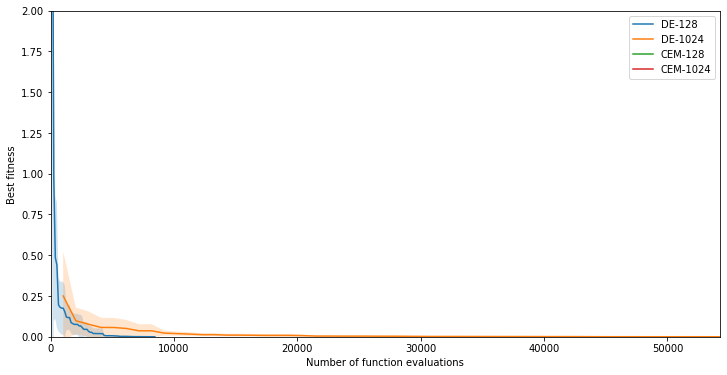

In [36]:
show_fig(all_fitness_de_128, evals_de_128, all_fitness_de_1024, evals_de_1024, all_fitness_cem_128, evals_cem_128, all_fitness_cem_1024, evals_cem_1024)

## DIMENSION = 10

In [37]:
dimension = 10

In [38]:
F_scale=0.8
cross_prob=0.7
num_elite = 10
sigma_init = 4
lower_bound = -6
upper_bound = 6
max_evals = 1e6
fobj = Rosenbrock_f
popsize = 32
mean_sphere_2d_DE = []
mean_sphere_2d_CEM = []
std_sphere_2d_DE = []
std_sphere_2d_CEM = []

while True:
  if popsize > 1024:
    break
  all_results_de = []
  all_fitness_de = []
  num_evals_de = []
  all_results_cem = []
  all_fitness_cem = []
  all_fitness_cem_temp = []
  num_evals_cem = []
  num_evals_cem_temp = []
  seed_number= 17520618

  for i in range(10):
    np.random.rand(seed_number)
    results_de, all_pops_de, generation_count_de, fitness_de, eval_de = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results_de.append(results_de[-1])
    all_fitness_de.append(fitness_de)
    num_evals_de.append(eval_de)
    results_cem, fitness_cem, evals_cem, generation_count_cem, all_pops_cem = CEM(fobj, dimension, [(lower_bound, upper_bound)]*dimension, popsize, num_elite, sigma_init, extra_std, max_evals)
    all_results_cem.append(results_cem[-1])
    all_fitness_cem.append(fitness_cem[-1])
    num_evals_cem.append(evals_cem[-1])
    all_fitness_cem_temp.append(fitness_cem)
    num_evals_cem_temp.append(evals_cem)
    seed_number += 1
  if popsize == 32:
    pop_de = all_pops_de
    pop_cem = all_pops_cem
  elif popsize == 128:
    all_fitness_de_128 = all_fitness_de
    evals_de_128 = num_evals_de
    all_fitness_cem_128 = all_fitness_cem_temp
    evals_cem_128 = num_evals_cem_temp
  elif popsize == 1024:
    all_fitness_de_1024 = all_fitness_de
    evals_de_1024 = num_evals_de
    all_fitness_cem_1024 = all_fitness_cem_temp
    evals_cem_1024 = num_evals_cem_temp
  
  print('popsize =', popsize)
  print('DE:')
  for i in range(10):
    print(all_results_de[i])
  print('---------------------------------------------------------')
  print('CEM')
  for i in range(10):
    print(all_results_cem[i], all_fitness_cem[i], num_evals_cem[i])

  print(f"Giá trị trung bình (mean) của Rosenbrock trong DE: {np.mean([all_results_de[i][1] for i in range(len(all_results_de))])}")
  mean_sphere_2d_DE.append(np.mean([all_results_de[i][1] for i in range(len(all_results_de))]))
  print(f"Độ lệch chuẩn (std) của Rosenbrock trong DE: {np.std([all_results_de[i][1] for i in range(len(all_results_de))])}")
  std_sphere_2d_DE.append(np.std([all_results_de[i][1] for i in range(len(all_results_de))]))
  print(f"Giá trị trung bình (mean) của Rosenbrock trong CEM: {np.mean([all_fitness_cem[i] for i in range(len(all_results_cem))])}")
  mean_sphere_2d_CEM.append(np.mean([all_fitness_cem[i] for i in range(len(all_results_cem))]))
  print(f"Độ lệch chuẩn (std) của Rosenbrock trong CEM: {np.std([all_fitness_cem[i] for i in range(len(all_results_cem))])}")
  std_sphere_2d_CEM.append(np.std([all_fitness_cem[i] for i in range(len(all_results_cem))]))
  print('===========================================================')

  popsize = popsize*2

popsize = 32
DE:
(array([0.99993836, 0.99997822, 0.99990167, 1.00000519, 0.99994797,
       0.99989693, 0.99989037, 0.99964665, 0.9992506 , 0.99849706]), 9.434771248585571e-06, 64321)
(array([1.00007665, 1.00006084, 0.99999975, 1.00005271, 1.00000548,
       1.00007543, 1.0001418 , 1.00015223, 1.00040508, 1.00066304]), 9.180950685387804e-06, 67009)
(array([0.99998136, 0.99997487, 0.99998357, 1.00009423, 0.99999647,
       1.00000538, 1.00017114, 1.00033092, 1.00057863, 1.00114886]), 9.216591306655249e-06, 68961)
(array([0.99996847, 0.99992417, 0.99996362, 0.99992329, 0.99986138,
       0.9997969 , 0.99963557, 0.99924   , 0.998424  , 0.99700117]), 8.049137382346422e-06, 66209)
(array([0.99994142, 0.99998084, 1.00001696, 0.99998223, 0.99996683,
       0.99990328, 0.99965884, 0.99941837, 0.9989322 , 0.99781182]), 7.6226744181345055e-06, 64161)
(array([1.00004921, 0.9999885 , 0.99994026, 0.99986894, 0.9998715 ,
       0.99980832, 0.99963294, 0.9991633 , 0.99834604, 0.9965673 ]), 9.95770724

In [39]:
for i in range(6):
  print('DE:', mean_sphere_2d_DE[i], std_sphere_2d_DE[i])
  print('CEM:', mean_sphere_2d_CEM[i], std_sphere_2d_CEM[i])

DE: 9.127670385095947e-06 7.392364621398148e-07
CEM: 4.430266616092021 1.1519846450361366
DE: 8.364917282439694e-06 9.229806993087861e-07
CEM: 2.430877693239318 1.1611815644694552
DE: 7.764891176695873e-06 1.4879065150433982e-06
CEM: 1.8967449510993155 1.4332485768223953
DE: 8.925602810495676e-06 5.617118838626203e-07
CEM: 1.893658104540944 1.5892178269042398
DE: 0.00012833738108445567 3.9038863540640275e-05
CEM: 1.2085480432033955 1.2135517338050652
DE: 0.3296468592843539 0.04154677572713767
CEM: 1.9446544189615431 1.8584656394348988


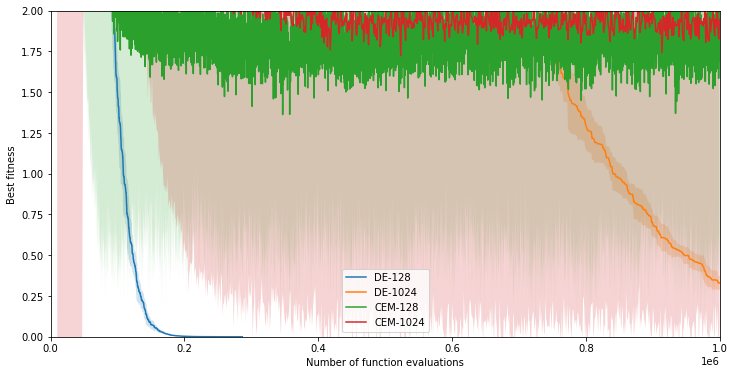

In [40]:
show_fig(all_fitness_de_128, evals_de_128, all_fitness_de_1024, evals_de_1024, all_fitness_cem_128, evals_cem_128, all_fitness_cem_1024, evals_cem_1024)

# **HÀM MICHALEWICZ**

## DIMENSION = 2

In [61]:
dimension = 2

In [77]:
F_scale=0.8
cross_prob=0.7
num_elite = 10
sigma_init = 4
lower_bound = 0
upper_bound = 3.14
max_evals = 1e5
fobj = Michalewicz_f
popsize = 32
mean_sphere_2d_DE = []
mean_sphere_2d_CEM = []
std_sphere_2d_DE = []
std_sphere_2d_CEM = []

while True:
  if popsize > 1024:
    break
  all_results_de = []
  all_fitness_de = []
  num_evals_de = []
  all_results_cem = []
  all_fitness_cem = []
  all_fitness_cem_temp = []
  num_evals_cem = []
  num_evals_cem_temp = []
  seed_number= 17520618

  for i in range(10):
    np.random.rand(seed_number)
    results_de, all_pops_de, generation_count_de, fitness_de, eval_de = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results_de.append(results_de[-1])
    all_fitness_de.append(fitness_de)
    num_evals_de.append(eval_de)
    results_cem, fitness_cem, evals_cem, generation_count_cem, all_pops_cem = CEM2(fobj, dimension, [(lower_bound, upper_bound)]*dimension, popsize, num_elite, sigma_init, extra_std, max_evals)
    all_results_cem.append(results_cem[-1])
    all_fitness_cem.append(fitness_cem[-1])
    num_evals_cem.append(evals_cem[-1])
    all_fitness_cem_temp.append(fitness_cem)
    num_evals_cem_temp.append(evals_cem)
    seed_number += 1
  if popsize == 32:
    pop_de = all_pops_de
    pop_cem = all_pops_cem
  elif popsize == 128:
    all_fitness_de_128 = all_fitness_de
    evals_de_128 = num_evals_de
    all_fitness_cem_128 = all_fitness_cem_temp
    evals_cem_128 = num_evals_cem_temp
  elif popsize == 1024:
    all_fitness_de_1024 = all_fitness_de
    evals_de_1024 = num_evals_de
    all_fitness_cem_1024 = all_fitness_cem_temp
    evals_cem_1024 = num_evals_cem_temp
  
  print('popsize =', popsize)
  print('DE:')
  for i in range(10):
    print(all_results_de[i])
  print('---------------------------------------------------------')
  print('CEM')
  for i in range(10):
    print(all_results_cem[i], all_fitness_cem[i], num_evals_cem[i])

  print(f"Giá trị trung bình (mean) của MICHALEWICZ trong DE: {np.mean([all_results_de[i][1] for i in range(len(all_results_de))])}")
  mean_sphere_2d_DE.append(np.mean([all_results_de[i][1] for i in range(len(all_results_de))]))
  print(f"Độ lệch chuẩn (std) của MICHALEWICZ trong DE: {np.std([all_results_de[i][1] for i in range(len(all_results_de))])}")
  std_sphere_2d_DE.append(np.std([all_results_de[i][1] for i in range(len(all_results_de))]))
  print(f"Giá trị trung bình (mean) của MICHALEWICZ trong CEM: {np.mean([all_fitness_cem[i] for i in range(len(all_results_cem))])}")
  mean_sphere_2d_CEM.append(np.mean([all_fitness_cem[i] for i in range(len(all_results_cem))]))
  print(f"Độ lệch chuẩn (std) của MICHALEWICZ trong CEM: {np.std([all_fitness_cem[i] for i in range(len(all_results_cem))])}")
  std_sphere_2d_CEM.append(np.std([all_fitness_cem[i] for i in range(len(all_results_cem))]))
  print('===========================================================')

  popsize = popsize*2

popsize = 32
DE:
(array([2.12018556, 1.48102999]), -1.4343558999052957, 33)
(array([0.9182133 , 1.62011766]), -0.9032389224166003, 33)
(array([0.60866758, 1.53876375]), -0.960068314680516, 33)
(array([2.14442801, 1.5624434 ]), -1.7460597745632818, 33)
(array([2.13227251, 1.51394322]), -1.6074605321952418, 33)
(array([1.90597621, 1.57817483]), -1.1587530867926485, 33)
(array([2.16451023, 1.62326175]), -1.6690784278908288, 33)
(array([1.38988325, 1.55933189]), -0.9947451231450597, 33)
(array([1.7593632 , 1.61072384]), -0.961560243251632, 33)
(array([1.91894424, 1.53002749]), -1.1199988977039734, 33)
---------------------------------------------------------
CEM
[2.2028887  1.57074803] -1.8013033591413832 100032
[2.20294057 1.57076226] -1.8013032573392018 100032
[2.20293531 1.57082207] -1.8013033324086538 100032
[2.20289534 1.57077242] -1.8013033995300165 100032
[2.20292296 1.57078344] -1.8013033029584478 100032
[2.202849   1.57080286] -1.8013033782938335 100032
[2.20291378 1.5707897 ] -1.

In [78]:
for i in range(6):
  print('DE:', mean_sphere_2d_DE[i], std_sphere_2d_DE[i])
  print('CEM:', mean_sphere_2d_CEM[i], std_sphere_2d_CEM[i])

DE: -1.2555319222545078 0.31000703140581465
CEM: -1.8013033520357182 4.117830751161936e-08
DE: -1.3518300685582925 0.2027695502477901
CEM: -1.8013033918734167 1.760985340995773e-08
DE: -1.702692578974699 0.07630482315462637
CEM: -1.8013034068113083 2.5846082529276855e-09
DE: -1.6919424615139254 0.09013068727373844
CEM: -1.801303405567234 5.5406596712685776e-09
DE: -1.7205959127280284 0.04799196738152281
CEM: -1.8013034090659759 8.458327231163906e-10
DE: -1.7584837090050247 0.05516925746518794
CEM: -1.801303409712569 3.6770049262793207e-10


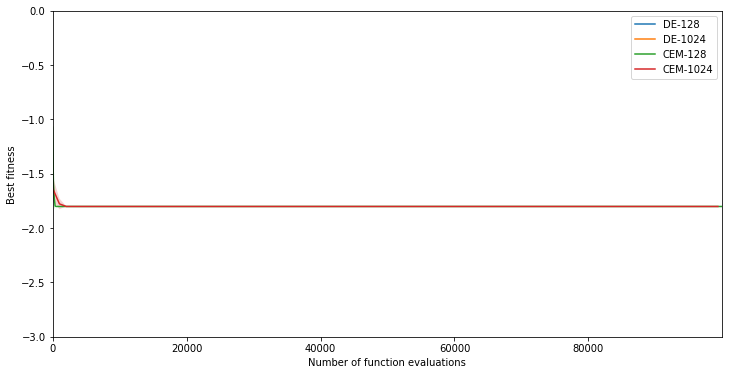

In [79]:
show_fig(all_fitness_de_128, evals_de_128, all_fitness_de_1024, evals_de_1024, all_fitness_cem_128, evals_cem_128, all_fitness_cem_1024, evals_cem_1024, -3, 0)

## DIMENSION = 10

In [80]:
dimension = 10

In [81]:
F_scale=0.8
cross_prob=0.7
num_elite = 10
sigma_init = 4
lower_bound = 0
upper_bound = 3.14
max_evals = 1e6
fobj = Michalewicz_f
popsize = 32
mean_sphere_2d_DE = []
mean_sphere_2d_CEM = []
std_sphere_2d_DE = []
std_sphere_2d_CEM = []

while True:
  if popsize > 1024:
    break
  all_results_de = []
  all_fitness_de = []
  num_evals_de = []
  all_results_cem = []
  all_fitness_cem = []
  all_fitness_cem_temp = []
  num_evals_cem = []
  num_evals_cem_temp = []
  seed_number= 17520618

  for i in range(10):
    np.random.rand(seed_number)
    results_de, all_pops_de, generation_count_de, fitness_de, eval_de = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results_de.append(results_de[-1])
    all_fitness_de.append(fitness_de)
    num_evals_de.append(eval_de)
    results_cem, fitness_cem, evals_cem, generation_count_cem, all_pops_cem = CEM2(fobj, dimension, [(lower_bound, upper_bound)]*dimension, popsize, num_elite, sigma_init, extra_std, max_evals)
    all_results_cem.append(results_cem[-1])
    all_fitness_cem.append(fitness_cem[-1])
    num_evals_cem.append(evals_cem[-1])
    all_fitness_cem_temp.append(fitness_cem)
    num_evals_cem_temp.append(evals_cem)
    seed_number += 1
  if popsize == 32:
    pop_de = all_pops_de
    pop_cem = all_pops_cem
  elif popsize == 128:
    all_fitness_de_128 = all_fitness_de
    evals_de_128 = num_evals_de
    all_fitness_cem_128 = all_fitness_cem_temp
    evals_cem_128 = num_evals_cem_temp
  elif popsize == 1024:
    all_fitness_de_1024 = all_fitness_de
    evals_de_1024 = num_evals_de
    all_fitness_cem_1024 = all_fitness_cem_temp
    evals_cem_1024 = num_evals_cem_temp
  
  print('popsize =', popsize)
  print('DE:')
  for i in range(10):
    print(all_results_de[i])
  print('---------------------------------------------------------')
  print('CEM')
  for i in range(10):
    print(all_results_cem[i], all_fitness_cem[i], num_evals_cem[i])

  print(f"Giá trị trung bình (mean) của MICHALEWICZ trong DE: {np.mean([all_results_de[i][1] for i in range(len(all_results_de))])}")
  mean_sphere_2d_DE.append(np.mean([all_results_de[i][1] for i in range(len(all_results_de))]))
  print(f"Độ lệch chuẩn (std) của MICHALEWICZ trong DE: {np.std([all_results_de[i][1] for i in range(len(all_results_de))])}")
  std_sphere_2d_DE.append(np.std([all_results_de[i][1] for i in range(len(all_results_de))]))
  print(f"Giá trị trung bình (mean) của MICHALEWICZ trong CEM: {np.mean([all_fitness_cem[i] for i in range(len(all_results_cem))])}")
  mean_sphere_2d_CEM.append(np.mean([all_fitness_cem[i] for i in range(len(all_results_cem))]))
  print(f"Độ lệch chuẩn (std) của MICHALEWICZ trong CEM: {np.std([all_fitness_cem[i] for i in range(len(all_results_cem))])}")
  std_sphere_2d_CEM.append(np.std([all_fitness_cem[i] for i in range(len(all_results_cem))]))
  print('===========================================================')

  popsize = popsize*2

popsize = 32
DE:
(array([2.36360131, 1.81985965, 2.7085031 , 1.18684936, 1.19344853,
       0.95924853, 0.71878284, 3.07475816, 0.51636655, 1.57254119]), -2.7539173195652706, 33)
(array([2.08305548, 1.43224545, 1.38383705, 1.46594109, 0.52750111,
       1.08628997, 0.37185454, 2.64364949, 1.64520145, 1.98393784]), -2.5319843044081076, 33)
(array([3.04891738, 1.4193095 , 1.16666538, 0.29934889, 3.11567638,
       1.32757522, 0.75565333, 2.0648706 , 1.95870165, 2.53967925]), -3.293345807547813, 33)
(array([1.87784882, 0.79203092, 1.56141777, 1.0467238 , 0.97192979,
       0.15315352, 1.51056895, 2.37877471, 0.39113957, 2.1001932 ]), -2.898263699143487, 33)
(array([3.14      , 1.86759828, 2.30982726, 1.16997866, 2.50184602,
       1.57701474, 1.43392034, 3.03703255, 0.08809181, 3.10696738]), -2.777655288376448, 33)
(array([2.64268768, 1.59417828, 0.05730442, 1.37752465, 1.73992528,
       1.00366232, 2.48816242, 0.03469673, 1.4352505 , 1.23742655]), -3.0104230095743927, 33)
(array([0.    

In [82]:
for i in range(6):
  print('DE:', mean_sphere_2d_DE[i], std_sphere_2d_DE[i])
  print('CEM:', mean_sphere_2d_CEM[i], std_sphere_2d_CEM[i])

DE: -3.0967015706187206 0.3996538248470945
CEM: -8.9181515702967 0.2995544667178195
DE: -3.3337001070650687 0.37269533825600565
CEM: -9.07565852934717 0.33891555878379
DE: -3.271967489305092 0.19824613544826172
CEM: -9.257238909869347 0.14248721144528176
DE: -3.699011929097261 0.23633072880114006
CEM: -9.365439101151333 0.11926937677236804
DE: -4.062865643549676 0.35010437580874965
CEM: -9.42498264379895 0.17341768734062435
DE: -4.20284309970161 0.4557647323449311
CEM: -9.49064781272611 0.12508098428771477


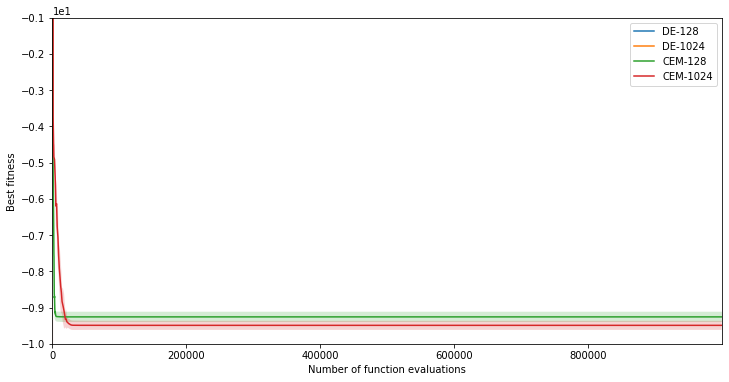

In [83]:
show_fig(all_fitness_de_128, evals_de_128, all_fitness_de_1024, evals_de_1024, all_fitness_cem_128, evals_cem_128, all_fitness_cem_1024, evals_cem_1024, -10, -1)

# **HÀM ACKLEY**

## DIMENSION = 2

In [53]:
dimension = 2

In [54]:
F_scale=0.8
cross_prob=0.7
num_elite = 10
sigma_init = 4
lower_bound = -6
upper_bound = 6
max_evals = 1e5
fobj = Ackley_f
popsize = 32
mean_sphere_2d_DE = []
mean_sphere_2d_CEM = []
std_sphere_2d_DE = []
std_sphere_2d_CEM = []

while True:
  if popsize > 1024:
    break
  all_results_de = []
  all_fitness_de = []
  num_evals_de = []
  all_results_cem = []
  all_fitness_cem = []
  all_fitness_cem_temp = []
  num_evals_cem = []
  num_evals_cem_temp = []
  seed_number= 17520618

  for i in range(10):
    np.random.rand(seed_number)
    results_de, all_pops_de, generation_count_de, fitness_de, eval_de = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results_de.append(results_de[-1])
    all_fitness_de.append(fitness_de)
    num_evals_de.append(eval_de)
    results_cem, fitness_cem, evals_cem, generation_count_cem, all_pops_cem = CEM(fobj, dimension, [(lower_bound, upper_bound)]*dimension, popsize, num_elite, sigma_init, extra_std, max_evals)
    all_results_cem.append(results_cem[-1])
    all_fitness_cem.append(fitness_cem[-1])
    num_evals_cem.append(evals_cem[-1])
    all_fitness_cem_temp.append(fitness_cem)
    num_evals_cem_temp.append(evals_cem)
    seed_number += 1
  if popsize == 32:
    pop_de = all_pops_de
    pop_cem = all_pops_cem
  elif popsize == 128:
    all_fitness_de_128 = all_fitness_de
    evals_de_128 = num_evals_de
    all_fitness_cem_128 = all_fitness_cem_temp
    evals_cem_128 = num_evals_cem_temp
  elif popsize == 1024:
    all_fitness_de_1024 = all_fitness_de
    evals_de_1024 = num_evals_de
    all_fitness_cem_1024 = all_fitness_cem_temp
    evals_cem_1024 = num_evals_cem_temp
  
  print('popsize =', popsize)
  print('DE:')
  for i in range(10):
    print(all_results_de[i])
  print('---------------------------------------------------------')
  print('CEM')
  for i in range(10):
    print(all_results_cem[i], all_fitness_cem[i], num_evals_cem[i])

  print(f"Giá trị trung bình (mean) của ACKLEY trong DE: {np.mean([all_results_de[i][1] for i in range(len(all_results_de))])}")
  mean_sphere_2d_DE.append(np.mean([all_results_de[i][1] for i in range(len(all_results_de))]))
  print(f"Độ lệch chuẩn (std) của ACKLEY trong DE: {np.std([all_results_de[i][1] for i in range(len(all_results_de))])}")
  std_sphere_2d_DE.append(np.std([all_results_de[i][1] for i in range(len(all_results_de))]))
  print(f"Giá trị trung bình (mean) của ACKLEY trong CEM: {np.mean([all_fitness_cem[i] for i in range(len(all_results_cem))])}")
  mean_sphere_2d_CEM.append(np.mean([all_fitness_cem[i] for i in range(len(all_results_cem))]))
  print(f"Độ lệch chuẩn (std) của ACKLEY trong CEM: {np.std([all_fitness_cem[i] for i in range(len(all_results_cem))])}")
  std_sphere_2d_CEM.append(np.std([all_fitness_cem[i] for i in range(len(all_results_cem))]))
  print('===========================================================')

  popsize = popsize*2

popsize = 32
DE:
(array([-1.53860134e-06,  1.45651283e-06]), 5.9925972988317255e-06, 1537)
(array([-2.17606045e-06, -9.05744955e-07]), 6.666849085679161e-06, 2049)
(array([1.50673557e-06, 1.28917122e-07]), 4.277323285339918e-06, 1793)
(array([ 2.97600971e-06, -1.81701105e-06]), 9.862641090041535e-06, 1793)
(array([-1.03657829e-06, -2.31947179e-07]), 3.0044188901179325e-06, 1793)
(array([-6.63138433e-07,  1.87353414e-06]), 5.621409468137273e-06, 1985)
(array([1.59963835e-07, 2.66588760e-06]), 7.554020811983975e-06, 1857)
(array([ 4.75136607e-07, -1.20830236e-08]), 1.3443297679494037e-06, 2145)
(array([-6.32572331e-07,  1.20507748e-06]), 3.849578629644412e-06, 2017)
(array([-2.02526952e-07,  3.48975231e-06]), 9.887443621625636e-06, 1921)
---------------------------------------------------------
CEM
[-0.96704195  0.96835944] 3.5749886648100078 100032
[ 0.00182663 -0.00319965] 0.035850879898327026 100032
[0.00209807 0.00365483] 0.01167588171635403 100032
[9.54872913e-01 4.21613532e-04] 2.5

In [55]:
for i in range(6):
  print('DE:', mean_sphere_2d_DE[i], std_sphere_2d_DE[i])
  print('CEM:', mean_sphere_2d_CEM[i], std_sphere_2d_CEM[i])

DE: 5.806061194935097e-06 2.6627024638033558e-06
CEM: 0.6363148016446584 1.2408239815892947
DE: 5.58034440709676e-06 2.6951509645620373e-06
CEM: 1.3010670288709503 1.27963504454864
DE: 5.289812959308194e-06 2.0469907930285243e-06
CEM: 0.7805035615917546 1.1781009502731234
DE: 6.897994361043658e-06 2.118024897971278e-06
CEM: 0.5212354737192022 1.0294088951503166
DE: 6.425636357310083e-06 2.306479691272215e-06
CEM: 0.8752271029552752 1.3575592808857166
DE: 7.372819267903452e-06 2.5180052516910967e-06
CEM: 0.7760236787760129 1.1809642184891953


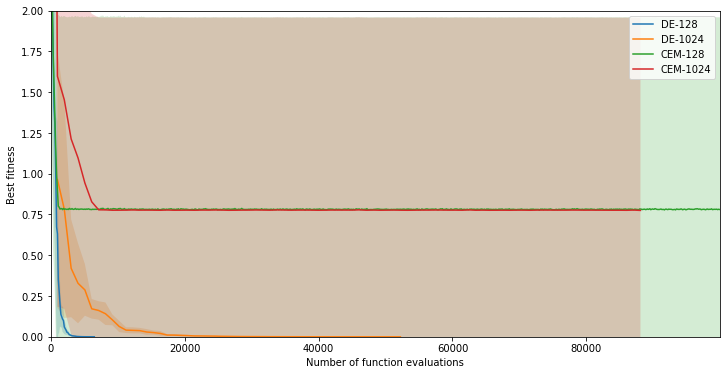

In [56]:
show_fig(all_fitness_de_128, evals_de_128, all_fitness_de_1024, evals_de_1024, all_fitness_cem_128, evals_cem_128, all_fitness_cem_1024, evals_cem_1024)

## DIMENSION = 10

In [57]:
dimension = 10

In [58]:
F_scale=0.8
cross_prob=0.7
num_elite = 10
sigma_init = 4
lower_bound = -6
upper_bound = 6
max_evals = 1e6
fobj = Ackley_f
popsize = 32
mean_sphere_2d_DE = []
mean_sphere_2d_CEM = []
std_sphere_2d_DE = []
std_sphere_2d_CEM = []

while True:
  if popsize > 1024:
    break
  all_results_de = []
  all_fitness_de = []
  num_evals_de = []
  all_results_cem = []
  all_fitness_cem = []
  all_fitness_cem_temp = []
  num_evals_cem = []
  num_evals_cem_temp = []
  seed_number= 17520618

  for i in range(10):
    np.random.rand(seed_number)
    results_de, all_pops_de, generation_count_de, fitness_de, eval_de = DE(fobj, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, popsize, max_evals)
    all_results_de.append(results_de[-1])
    all_fitness_de.append(fitness_de)
    num_evals_de.append(eval_de)
    results_cem, fitness_cem, evals_cem, generation_count_cem, all_pops_cem = CEM(fobj, dimension, [(lower_bound, upper_bound)]*dimension, popsize, num_elite, sigma_init, extra_std, max_evals)
    all_results_cem.append(results_cem[-1])
    all_fitness_cem.append(fitness_cem[-1])
    num_evals_cem.append(evals_cem[-1])
    all_fitness_cem_temp.append(fitness_cem)
    num_evals_cem_temp.append(evals_cem)
    seed_number += 1
  if popsize == 32:
    pop_de = all_pops_de
    pop_cem = all_pops_cem
  elif popsize == 128:
    all_fitness_de_128 = all_fitness_de
    evals_de_128 = num_evals_de
    all_fitness_cem_128 = all_fitness_cem_temp
    evals_cem_128 = num_evals_cem_temp
  elif popsize == 1024:
    all_fitness_de_1024 = all_fitness_de
    evals_de_1024 = num_evals_de
    all_fitness_cem_1024 = all_fitness_cem_temp
    evals_cem_1024 = num_evals_cem_temp
  
  print('popsize =', popsize)
  print('DE:')
  for i in range(10):
    print(all_results_de[i])
  print('---------------------------------------------------------')
  print('CEM')
  for i in range(10):
    print(all_results_cem[i], all_fitness_cem[i], num_evals_cem[i])

  print(f"Giá trị trung bình (mean) của ACKLEY trong DE: {np.mean([all_results_de[i][1] for i in range(len(all_results_de))])}")
  mean_sphere_2d_DE.append(np.mean([all_results_de[i][1] for i in range(len(all_results_de))]))
  print(f"Độ lệch chuẩn (std) của ACKLEY trong DE: {np.std([all_results_de[i][1] for i in range(len(all_results_de))])}")
  std_sphere_2d_DE.append(np.std([all_results_de[i][1] for i in range(len(all_results_de))]))
  print(f"Giá trị trung bình (mean) của ACKLEY trong CEM: {np.mean([all_fitness_cem[i] for i in range(len(all_results_cem))])}")
  mean_sphere_2d_CEM.append(np.mean([all_fitness_cem[i] for i in range(len(all_results_cem))]))
  print(f"Độ lệch chuẩn (std) của ACKLEY trong CEM: {np.std([all_fitness_cem[i] for i in range(len(all_results_cem))])}")
  std_sphere_2d_CEM.append(np.std([all_fitness_cem[i] for i in range(len(all_results_cem))]))
  print('===========================================================')

  popsize = popsize*2

popsize = 32
DE:
(array([-1.41252308e-06,  1.36050141e-06, -1.54313934e-06, -2.08926215e-06,
        9.55245290e-07,  1.08177986e-06,  3.54567873e-06,  2.90157033e-06,
        1.64983640e-06, -2.34550742e-06]), 8.1869963648451e-06, 18689)
(array([ 1.29252333e-06,  1.20179087e-06, -1.29736874e-06, -4.75366966e-06,
       -2.37242122e-06, -6.49653981e-07,  2.15646619e-06, -3.44187931e-06,
       -1.30388860e-06,  1.63305599e-06]), 9.322071765627271e-06, 19521)
(array([-3.04320239e-06,  5.20481446e-07,  1.83611552e-06,  1.67031599e-06,
       -2.06364129e-07,  2.79163501e-06,  2.10329655e-06, -1.78132679e-06,
        8.81368044e-07, -4.09384515e-06]), 8.824084073655314e-06, 18465)
(array([-2.73557463e-06, -2.82770717e-06,  2.39871366e-06, -1.58358877e-06,
        2.64069083e-07,  2.38500117e-06,  1.16607798e-06, -9.91508173e-07,
        1.82017156e-06,  1.27376426e-06]), 7.671145354937181e-06, 18977)
(array([ 2.77001564e-06, -1.15637002e-07,  2.49503180e-06, -8.52170570e-09,
        1.549

In [59]:
for i in range(6):
  print('DE:', mean_sphere_2d_DE[i], std_sphere_2d_DE[i])
  print('CEM:', mean_sphere_2d_CEM[i], std_sphere_2d_CEM[i])

DE: 8.73113422672489e-06 5.162519675491544e-07
CEM: 1.5854144630420588 1.0455341374293796
DE: 9.35084164703781e-06 5.772146988926744e-07
CEM: 2.4678297635134454 0.532791564934359
DE: 8.805728318339589e-06 9.572831590882512e-07
CEM: 2.231930289246115 0.5602206027780683
DE: 9.137405948056455e-06 8.140331799033451e-07
CEM: 2.4995127492471676 0.5538512445133729
DE: 9.38841427009507e-06 8.151077632573405e-07
CEM: 2.2006754583158408 0.9425754167358066
DE: 8.949285055326328e-06 6.448627182987463e-07
CEM: 1.9895536314395117 0.7928586557105475


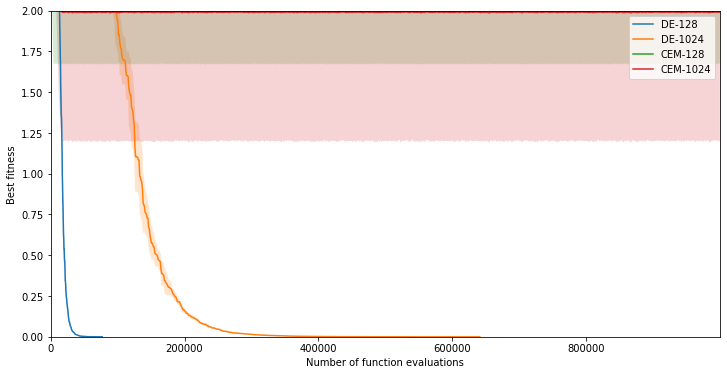

In [60]:
show_fig(all_fitness_de_128, evals_de_128, all_fitness_de_1024, evals_de_1024, all_fitness_cem_128, evals_cem_128, all_fitness_cem_1024, evals_cem_1024)